In [ ]:
pip install cvxpy==1.1.8

  Using cached https://files.pythonhosted.org/packages/e6/3b/6a6650ed48503c4e4b2f497ce40517fe427f3cfacfc8fb43ff52f89bc4c8/cvxpy-1.1.8.tar.gz
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
ERROR: Some build dependencies for cvxpy==1.1.8 from https://files.pythonhosted.org/packages/e6/3b/6a6650ed48503c4e4b2f497ce40517fe427f3cfacfc8fb43ff52f89bc4c8/cvxpy-1.1.8.tar.gz#sha256=444068d4eda9ffcd43578895174489d4cef36b28ba7ae8a96ab9ef9571d2b4ff conflict with the backend dependencies: numpy==1.13.3 is incompatible with numpy>=1.15.


In [ ]:
pip install --upgrade tensorflow-probability

Requirement already up-to-date: tensorflow-probability in /usr/local/lib/python3.6/dist-packages (0.12.1)


In [ ]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections

import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

tf.enable_v2_behavior()

In [ ]:

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

In [ ]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):

  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast


  ax.plot(x, y, lw=2, color=c1, label='Actual')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='Model Prediction')
  ax.fill_between(forecast_steps,
                   forecast_mean-1*forecast_scale,
                   forecast_mean+1*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

In [ ]:
vaccine_data = np.array('3506,48361,156659,267480,403467,169719,99936,370785,436636,552310,189132,11777,134177,89939,558784,685553,801902,403029,36631,238540,121488,606188,762647,941907,1079389,1141523,466303,226540,984027,1149958,1224373,1214291,1152264,595829,273846,784481,1227657,1482140,1490074,1481424,826313,351577,1227043,1509713,1744560,1756738,1693453,902399,395592,1134935,1459943,1878789,2033439,2040619,1130476,376105,1323843,1609812,1653737,1303142,216128'.split(',')).astype(np.float32)

vaccine_data = vaccine_data
num_forecast_steps = 14 
vaccine_training_data = vaccine_data[:-num_forecast_steps]

vaccine_dates = np.arange("2020-12-14", "2021-02-13", dtype="datetime64[D]")
vaccine_loc = mdates.YearLocator(3)
vaccine_fmt = mdates.DateFormatter('%Y')

In [ ]:
def build_model(observed_time_series):
  trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
  weekly = tfp.sts.Seasonal(
      num_seasons=7, observed_time_series=observed_time_series)
  model = sts.Sum([trend, weekly], observed_time_series=observed_time_series)
  return model

In [ ]:
vaccine_model = build_model(vaccine_training_data)

variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=vaccine_model)

Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


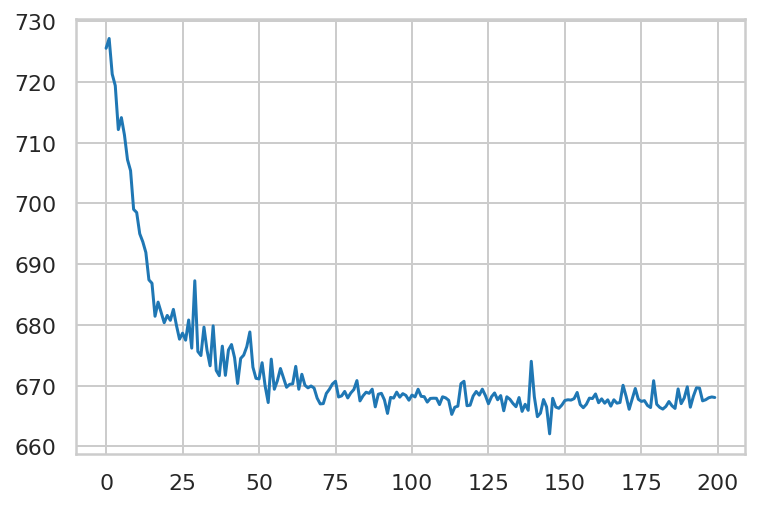

In [ ]:
num_variational_steps = 200 # @param {isTemplate: true}
num_variational_steps = int(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)

@tf.function(experimental_compile=True)
def train():
  elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=vaccine_model.joint_log_prob(
        observed_time_series=vaccine_training_data),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
  return elbo_loss_curve

elbo_loss_curve = train()

plt.plot(elbo_loss_curve)
plt.show()

q_samples_vaccine_ = variational_posteriors.sample(50)

In [ ]:
vaccine_forecast_dist = tfp.sts.forecast(
    model=vaccine_model,
    observed_time_series=vaccine_training_data,
    parameter_samples=q_samples_vaccine_,
    num_steps_forecast=num_forecast_steps)

In [ ]:
num_samples=10

vaccine_forecast_mean, vaccine_forecast_scale, vaccine_forecast_samples = (
    vaccine_forecast_dist.mean().numpy()[..., 0],
    vaccine_forecast_dist.stddev().numpy()[..., 0],
    vaccine_forecast_dist.sample(num_samples).numpy()[..., 0])

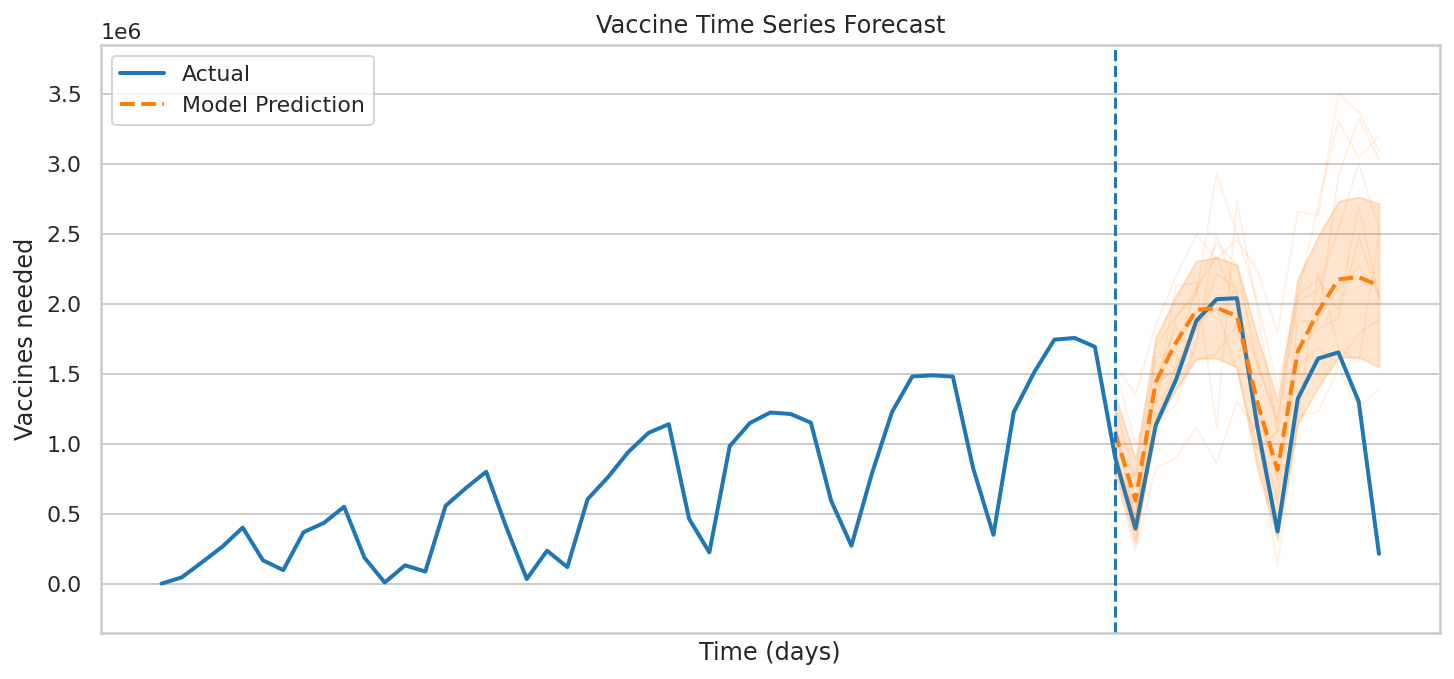

In [ ]:
fig, ax = plot_forecast(
    vaccine_dates, vaccine_data,
    vaccine_forecast_mean, vaccine_forecast_scale, vaccine_forecast_samples,
    x_locator=vaccine_loc,
    x_formatter=vaccine_fmt,
    title="Vaccine Time Series Forecast")
ax.axvline(vaccine_dates[-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("Vaccines needed")
ax.set_xlabel("Time (days)")
fig.autofmt_xdate()


In [ ]:
vaccine_dates
vaccine_data

array([   3506.,   48361.,  156659.,  267480.,  403467.,  169719.,
         99936.,  370785.,  436636.,  552310.,  189132.,   11777.,
        134177.,   89939.,  558784.,  685553.,  801902.,  403029.,
         36631.,  238540.,  121488.,  606188.,  762647.,  941907.,
       1079389., 1141523.,  466303.,  226540.,  984027., 1149958.,
       1224373., 1214291., 1152264.,  595829.,  273846.,  784481.,
       1227657., 1482140., 1490074., 1481424.,  826313.,  351577.,
       1227043., 1509713., 1744560., 1756738., 1693453.,  902399.,
        395592., 1134935., 1459943., 1878789., 2033439., 2040619.,
       1130476.,  376105., 1323843., 1609812., 1653737., 1303142.,
        216128.], dtype=float32)

In [ ]:
pip install numpy==1.19.3


In [ ]:
import pandas as pd
import numpy as np

sigma = np.loadtxt('https://raw.githubusercontent.com/kelechiu10/covex/main/data/sigma.csv')
y = np.loadtxt('https://raw.githubusercontent.com/kelechiu10/covex/main/data/y.csv')
A = np.loadtxt('https://raw.githubusercontent.com/kelechiu10/covex/main/data/A.csv', delimiter=",")
# sigma = pd.read_csv('https://raw.githubusercontent.com/kelechiu10/covex/main/data/sigma.csv', header=None)
# y = pd.read_csv('https://raw.githubusercontent.com/kelechiu10/covex/main/data/y.csv', header=None)
# A = pd.read_csv('https://raw.githubusercontent.com/kelechiu10/covex/main/data/A.csv', header=None)


In [ ]:
pip install cvxpy==1.1.8

  Using cached https://files.pythonhosted.org/packages/e6/3b/6a6650ed48503c4e4b2f497ce40517fe427f3cfacfc8fb43ff52f89bc4c8/cvxpy-1.1.8.tar.gz
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
ERROR: Some build dependencies for cvxpy==1.1.8 from https://files.pythonhosted.org/packages/e6/3b/6a6650ed48503c4e4b2f497ce40517fe427f3cfacfc8fb43ff52f89bc4c8/cvxpy-1.1.8.tar.gz#sha256=444068d4eda9ffcd43578895174489d4cef36b28ba7ae8a96ab9ef9571d2b4ff conflict with the backend dependencies: numpy==1.13.3 is incompatible with numpy>=1.15.


In [ ]:
y = np.squeeze(y)
sigma = np.squeeze(sigma)
y = np.array(y.astype(float))
y

array([ 50833.07823238, 137924.87616148,   4481.62419347, 102732.42644838,
        35883.54553526,  57639.82260514, 150578.94985495,  70672.86900271,
        75992.56581546,  51303.30944738, 160609.58559715,   5658.91925832,
       134921.79400962, 109655.13838727,  68126.88713293,  84300.37663957,
        49080.93138279,  63363.11995181,  28024.70584725, 197346.07499097,
       122405.06608781,  53222.79854609,  44644.05246975,  38166.26523111,
       111432.55111842,  36606.16358874,  25462.26491545,  34082.67429127,
        28955.56644661, 146344.12005958,  41647.27580432,  59096.63687491,
       159690.46838676, 170309.88144938, 146377.26875826, 135834.17086752,
        90573.70527782,  72042.25908424,  46939.07048869,  25004.03493915,
        13280.45772139,  13775.52925618,   5861.86956181, 315179.67535948,
       238462.49104897, 193561.32275226, 197723.26064978, 184801.28242771,
       179578.18900149, 144500.32488232, 143372.93629409, 134791.69187148,
       134551.07335313, 1

In [ ]:
from scipy import special
import cvxpy as cp
import matplotlib.pyplot as plt
import math


A = A.astype(float)
def optim_prob(perc, y, sigma, A, rad):
    cut = 1 * (A <= rad)
    cut = cut.astype('float')
    print(cut.shape)
    gamma = np.sqrt(2)*special.erfinv(perc)
    xi = np.square(sigma).astype('float')
    std = np.sqrt(np.matmul(cut,xi))
    B = cut*y+gamma*std
    B = np.squeeze(B)
    x = cp.Variable((np.size(y), 1))
    prob = cp.Problem(cp.Minimize(cp.norm1(x)),[cut @ x >= B])
    prob.solve()
    return (prob.value, x.value)
#naive method
ans = optim_prob(0.99,y,sigma,A,0)
#our method
ans = optim_prob(0.99,y,sigma,A,10)

(126, 126)


ValueError: ignored